In [1]:
import numpy as np
import cmocean.cm as cmo
import matplotlib.pyplot as plt
import xarray as xr
import xgcm
import gsw
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
plt.rcParams['font.size']=14

In [2]:
def fix_dimension(ds, bad_dim, new_dim, trim=True):
    assert len(ds[bad_dim]) == (len(ds[new_dim]) + 1)
    if trim and (len(ds[bad_dim]) == (len(ds[new_dim]) + 1)):
        ds = ds.isel(**{bad_dim: slice(0,-1)})
        assert len(ds[bad_dim]) == len(ds[new_dim])
    swapped_vars = []
    for v in ds:
        # replace naughty dimension
        dims = list(ds[v].dims)
        if bad_dim in dims:
            idx = dims.index(bad_dim)
            dims[idx] = new_dim
            ds[v].variable.dims = dims
            swapped_vars.append(v)
    return ds, swapped_vars

def reset_dimensions(ds, orig_dim, new_dim, *reset_vars):
    for v in reset_vars:
        dims = list(ds[v].dims)
        if new_dim in dims:
            idx = dims.index(new_dim)
            dims[idx] = orig_dim
            ds[v].variable.dims = dims
    # reindexing necessary to figure out new dims
    return ds.reindex()

def open_mncdataset(fname_base, ntiles_y, ntiles_x, iternum=None):
    if iternum is not None:
        itersuf = '.%010d' % iternum
    else:
        itersuf = ''
    dsets_y = []
    for ny in range(ntiles_y):
        dsets_x = []
        swap_vars = set()
        for nx in range(ntiles_x):
            ntile = nx + ntiles_x*ny + 1
            fname = fname_base + '%s.t%03d.nc' % (itersuf, ntile)
            ds = xr.open_dataset(fname)
            ds, swapped_vars_x = fix_dimension(ds, 'Xp1', 'X')    
            ds = ds.chunk()
            dsets_x.append(ds)
        ds_xconcat = xr.concat(dsets_x, 'X')
        ds_xconcat, swapped_vars_y = fix_dimension(ds_xconcat, 'Yp1', 'Y')
        dsets_y.append(ds_xconcat)
    ds = xr.concat(dsets_y, 'Y')
    ds = reset_dimensions(ds, 'Xp1', 'X', *swapped_vars_x)
    ds = reset_dimensions(ds, 'Yp1', 'Y', *swapped_vars_y)
    return ds



In [3]:



# real stratificiation; thermal wind balanced
dss = open_mncdataset('run_bump5000_real_tw/state', 2, 3, 0)
dsg = open_mncdataset('run_bump5000_real_tw/grid', 2, 3, None)
dsbrt=xr.merge((dss,dsg))
dsbrt=dsbrt.isel(Zp1=slice(0,-1))
dsbrt['Z']=-1*dsbrt.Z
dsbrt['Zl']=-1*dsbrt.Zl
dsbrt=dsbrt.rename_dims({'Xp1':'X_left','Yp1':'Y_left','Zp1':'Z_left'})
dsbrt=xgcm.generate_grid_ds(dsbrt, {'X':'X', 'Y':'Y', 'Z':'Z'})
dsbrt.coords['day']=dsbrt.T/(24*3600)
dsbrt.coords['month']=dsbrt.day/30
# add to thermal wind a barotropic inflow condition
dss = open_mncdataset('run_bump5000_real_utw/state', 2, 3, 0)
dsg = open_mncdataset('run_bump5000_real_utw/grid', 2, 3, None)
dsbrtu=xr.merge((dss,dsg))
dsbrtu['Z']=-1*dsbrtu.Z
dsbrtu['Zl']=-1*dsbrtu.Zl
dsbrtu=dsbrtu.isel(Zp1=slice(0,-1))
dsbrtu=dsbrtu.rename_dims({'Xp1':'X_left','Yp1':'Y_left','Zp1':'Z_left'})
dsbrtu=xgcm.generate_grid_ds(dsbrtu, {'X':'X', 'Y':'Y', 'Z':'Z'})
dsbrtu.coords['day']=dsbrtu.T/(24*3600)
dsbrtu.coords['month']=dsbrtu.day/30

In [4]:
dsbrt['drU']=dsbrt.U.isel(T=0)*0+dsbrt.drF.isel(X=30,Y=20)
dsbrt['drV']=dsbrt.V.isel(T=0)*0+dsbrt.drF.isel(X=30,Y=20)
metrics = {
    ('X',): ['dxC', 'dxG', 'dxV'], # X distances
    ('Y',): ['dyC', 'dyG', 'dyU'], # Y distances
    ('Z',): ['drC', 'drF', 'drU', 'drV'], # Z distances
    }
grid = xgcm.Grid(dsbrt, periodic=False, metrics=metrics)

In [5]:
dsbrtu

<xarray.Dataset>
Dimensions:  (T: 123, X: 60, X_left: 60, Y: 40, Y_left: 40, Z: 100, Z_left: 100, Zl: 100, Zu: 100)
Coordinates: (12/14)
    Yp1      (Y_left) float64 0.0 2.5e+04 5e+04 ... 9.25e+05 9.5e+05 9.75e+05
    Xp1      (X_left) float64 0.0 2.5e+04 5e+04 ... 1.425e+06 1.45e+06 1.475e+06
  * T        (T) float64 0.0 2.592e+06 5.184e+06 ... 3.136e+08 3.154e+08
  * Y        (Y) float64 1.25e+04 3.75e+04 6.25e+04 ... 9.625e+05 9.875e+05
  * Z        (Z) float64 25.0 75.0 125.0 175.0 ... 4.875e+03 4.925e+03 4.975e+03
  * X        (X) float64 1.25e+04 3.75e+04 6.25e+04 ... 1.462e+06 1.488e+06
    ...       ...
  * Zu       (Zu) float64 -50.0 -100.0 -150.0 ... -4.9e+03 -4.95e+03 -5e+03
  * X_left   (X_left) float64 0.0 2.5e+04 5e+04 ... 1.425e+06 1.45e+06 1.475e+06
  * Y_left   (Y_left) float64 0.0 2.5e+04 5e+04 ... 9.25e+05 9.5e+05 9.75e+05
  * Z_left   (Z_left) float64 0.0 50.0 100.0 150.0 ... 4.85e+03 4.9e+03 4.95e+03
    day      (T) float64 0.0 30.0 60.0 90.0 ... 3.6e+03 3.63e+03 3.65e+03
    month    (T) float64 0.0 1.0 2.0 3.0 4.0 ... 118.0 119.0 120.0 121.0 121.7
Data variables: (12/37)
    iter     (Y, X, T) int32 dask.array<chunksize=(20, 20, 123), meta=np.ndarray>
    U        (T, Z, Y, X_left) float32 dask.array<chunksize=(123, 100, 20, 20), meta=np.ndarray>
    V        (T, Z, Y_left, X) float32 dask.array<chunksize=(123, 100, 20, 20), meta=np.ndarray>
    Temp     (T, Z, Y, X) float32 dask.array<chunksize=(123, 100, 20, 20), meta=np.ndarray>
    S        (T, Z, Y, X) float32 dask.array<chunksize=(123, 100, 20, 20), meta=np.ndarray>
    Eta      (T, Y, X) float32 dask.array<chunksize=(123, 20, 20), meta=np.ndarray>
    ...       ...
    R_low    (Y, X) float64 dask.array<chunksize=(20, 20), meta=np.ndarray>
    Ro_surf  (Y, X) float64 dask.array<chunksize=(20, 20), meta=np.ndarray>
    Depth    (Y, X) float64 dask.array<chunksize=(20, 20), meta=np.ndarray>
    HFacC    (Z, Y, X) float64 dask.array<chunksize=(100, 20, 20), meta=np.ndarray>
    HFacW    (Z, Y, X_left) float64 dask.array<chunksize=(100, 20, 20), meta=np.ndarray>
    HFacS    (Z, Y_left, X) float64 dask.array<chunksize=(100, 20, 20), meta=np.ndarray>

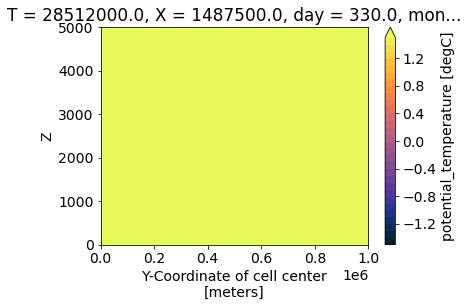

In [6]:
dsbrtu.Temp.isel(T=11,X=59).plot.pcolormesh(vmin=-1.5,vmax=1.5,levels=31,cmap=cmo.thermal)

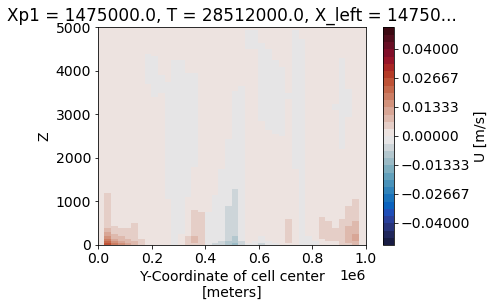

In [7]:
dsbrt.U.isel(T=11,X_left=59).plot.pcolormesh(vmin=-.05,vmax=0.05,levels=31,cmap=cmo.balance)

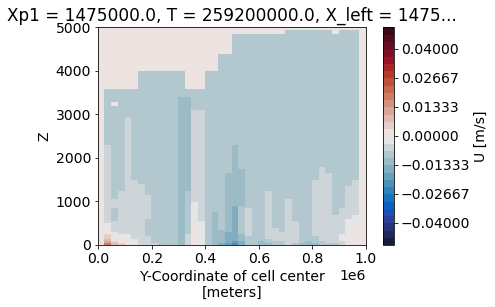

In [8]:
dsbrtu.U.isel(T=100,X_left=59).plot.pcolormesh(vmin=-.05,vmax=0.05,levels=31,cmap=cmo.balance)

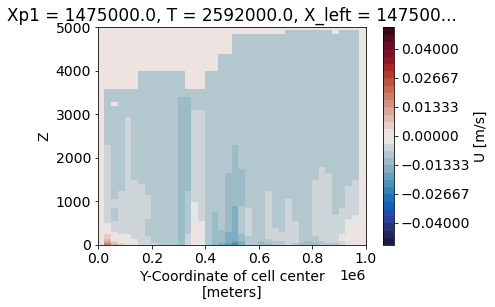

In [9]:
dsbrtu.U.isel(T=1,X_left=59).plot.pcolormesh(vmin=-.05,vmax=0.05,levels=31,cmap=cmo.balance)

# Analysis

Text(0, 0.5, 'Y-Distance [m]')

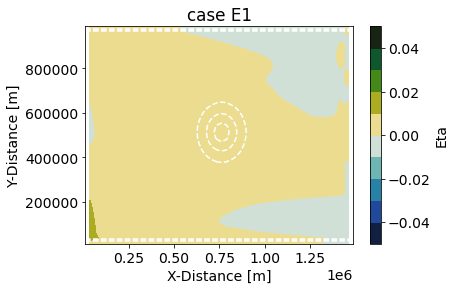

In [10]:
t=-1
cmap2=cmo.delta
lev=11
plt.figure()
(dsbrt.Eta.isel(T=t)-dsbrt.Eta.isel(T=-1,X=57)).isel(X=slice(1,-1)).plot.contourf(cmap=cmap2,vmin=-0.05,vmax=0.05,levels=lev)
#(dsbrt.Eta.isel(T=t)).isel(X=slice(1,-1)).plot.contourf(cmap=cmo.delta,vmin=-0.05,vmax=0.05,levels=lev)
dsbrt.Depth.plot.contour(levels=[2500,3500,4500],linestyles='--',colors='w')

plt.title(f'case E1')
plt.xlabel('X-Distance [m]')
plt.ylabel('Y-Distance [m]')



Text(0, 0.5, 'Y-Distance [m]')

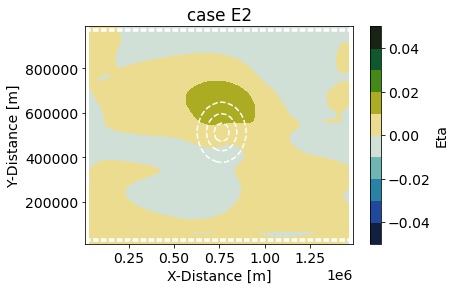

In [11]:
plt.figure()
(dsbrtu.Eta.isel(T=-1)-dsbrtu.Eta.isel(T=-1,X=58)).isel(X=slice(1,-1)).plot.contourf(cmap=cmo.delta,vmin=-0.05,vmax=0.05,levels=lev)
#(dsbrtu.Eta.isel(T=t)).isel(X=slice(1,-1)).plot.contourf(cmap=cmap2,vmin=-0.05,vmax=0.05,levels=lev)
dsbrt.Depth.plot.contour(levels=[2500,3500,4500],linestyles='--',colors='w')

plt.title(f'case E2')
plt.xlabel('X-Distance [m]')
plt.ylabel('Y-Distance [m]')


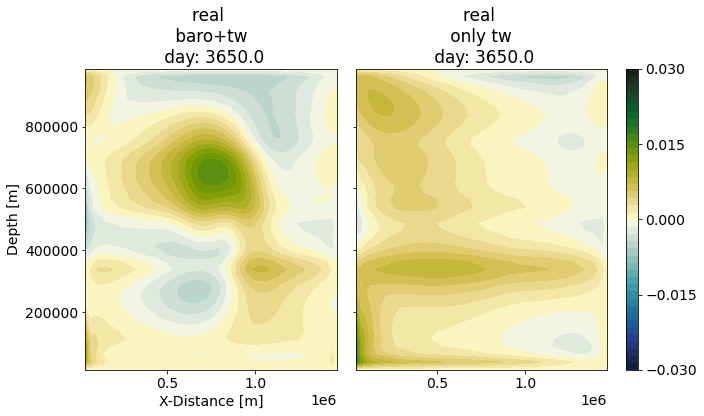

In [12]:
#plot T section  for 20 layer cases
t=-1
arr=3
wmin=-0.03
wmax=0.03
cmap2=cmo.delta
lev=43
xx=58
fig,axes=plt.subplots(1,3,figsize=(10,6),gridspec_kw={'width_ratios':[1,1,0.05]})


ax=axes[0]
(dsbrtu.Eta.isel(T=-1)-dsbrtu.Eta.isel(T=-1,X=xx)).isel(X=slice(1,-1)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)
ax.set_title(f'real \n baro+tw \n day: {dsbrt.day.isel(T=t).values}')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('Depth [m]')

ax=axes[1]
cb=(dsbrt.Eta.isel(T=-1)-dsbrt.Eta.isel(T=-1,X=xx)).isel(X=slice(1,-1)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)
ax.set_title(f'real \n only tw \n day: {dsbrt.day.isel(T=t).values}')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_yticklabels('')

cbar=plt.colorbar(cb,cax=axes[2], ticks=np.linspace(wmin,wmax,5))
plt.tight_layout()

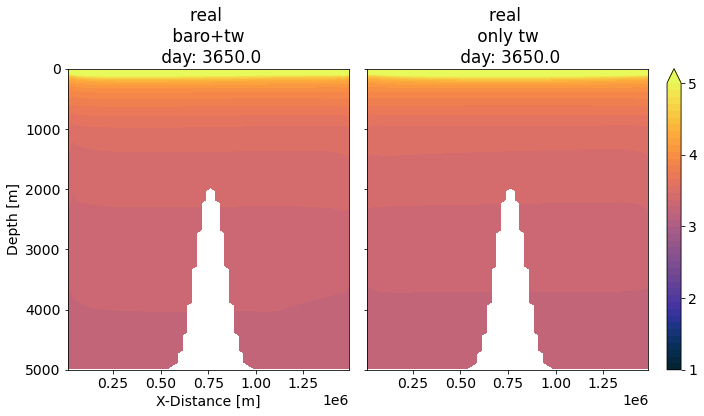

In [13]:
#plot T section  for 20 layer cases
t=-1
arr=3
wmin=1
wmax=5
cmap2=cmo.thermal
lev=43

fig,axes=plt.subplots(1,3,figsize=(10,6),gridspec_kw={'width_ratios':[1,1,0.05]})


ax=axes[0]
dsbrtu.Temp.where(dsbrtu.S!=0).isel(T=t,Y=20).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)
ax.fill_between(dsbrtu.X,(-1*dsbrtu.Depth).isel(Y=20),-5000,color='grey')
ax.set_title(f'real \n baro+tw \n day: {dsbrtu.day.isel(T=t).values}')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('Depth [m]')
ax.set_ylim((5000,0))

ax=axes[1]
cb=(dsbrt.Temp.where(dsbrt.S!=0).isel(T=t,Y=20)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)
#dsbrt.Temp.where(dsbrt.Temp>0).isel(T=t,Y=20).plot.contour(ax=ax,colors=['lightblue','b','purple','coral','r','yellow'],levels=[4.0,4.25,4.5,4.75,5,5.25])
ax.fill_between(dsbrt.X,(-1*dsbrt.Depth).isel(Y=20),-5000,color='grey')
ax.set_title(f'real \n only tw \n day: {dsbrt.day.isel(T=t).values}')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim((5000,0))
ax.set_yticklabels('')

cbar=plt.colorbar(cb,cax=axes[2], ticks=np.linspace(wmin,wmax,5))
plt.tight_layout()

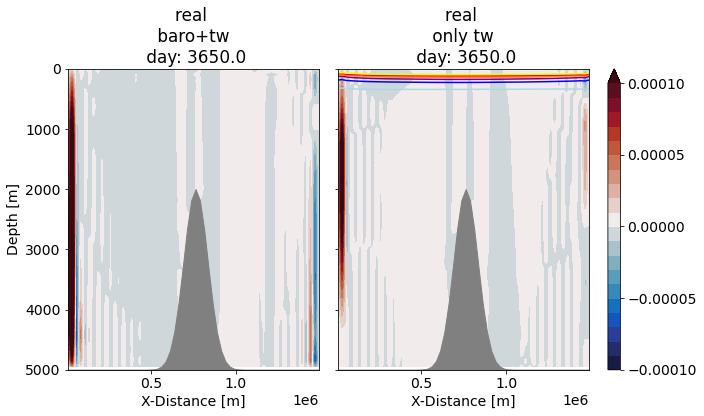

In [14]:
#plot T section  for 20 layer cases
t=-1
arr=3
wmin=-0.0001
wmax=0.0001
cmap2=cmo.balance
lev=21

fig,axes=plt.subplots(1,3,figsize=(10,6),gridspec_kw={'width_ratios':[1,1,0.05]})


ax=axes[0]
dsbrtu.W.isel(T=t,Y=20).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)
ax.fill_between(dsbrtu.X,(dsbrtu.Depth).isel(Y=20),5000,color='grey')
ax.set_title(f'real \n baro+tw \n day: {dsbrtu.day.isel(T=t).values}')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('Depth [m]')
ax.set_ylim((5000,0))

ax=axes[1]
cb=(dsbrt.W.isel(T=t,Y=20)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)
dsbrt.Temp.where(dsbrt.Temp>0).isel(T=t,Y=20).plot.contour(ax=ax,colors=['lightblue','b','purple','coral','r','yellow'],levels=[4.0,4.25,4.5,4.75,5,5.25])
ax.fill_between(dsbrt.X,(dsbrt.Depth).isel(Y=20),5000,color='grey')
ax.set_title(f'real \n only tw \n day: {dsbrt.day.isel(T=t).values}')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('')
ax.set_ylim((5000,0))
ax.set_yticklabels('')

cbar=plt.colorbar(cb,cax=axes[2], ticks=np.linspace(wmin,wmax,5))
plt.tight_layout()

In [15]:
# compute streamfunctions for all along U since the boundaries are closed
dsbrt['psi'] = grid.cumint(-grid.integrate(dsbrt.U,'Z'),'Y', boundary='fill')/1e6
dsbrtu['psi'] = grid.cumint(-grid.integrate(dsbrtu.U,'Z'),'Y', boundary='fill')/1e6

# relative vorticity
dsbrt['ze']=-1*grid.derivative(dsbrt.U,'Y',boundary='extend')+(grid.derivative(dsbrt.V,'X',boundary='extend'))
dsbrtu['ze']=-1*grid.derivative(dsbrtu.U,'Y',boundary='extend')+(grid.derivative(dsbrtu.V,'X',boundary='extend'))


In [16]:
dsbrt['U_baro'] = (dsbrt.U*dsbrt.drU).sum(dim='Z')
dsbrt['V_baro'] = (dsbrt.V*dsbrt.drV).sum(dim='Z')
dsbrtu['U_baro'] = (dsbrtu.U*dsbrt.drU).sum(dim='Z')
dsbrtu['V_baro'] = (dsbrtu.V*dsbrt.drV).sum(dim='Z')

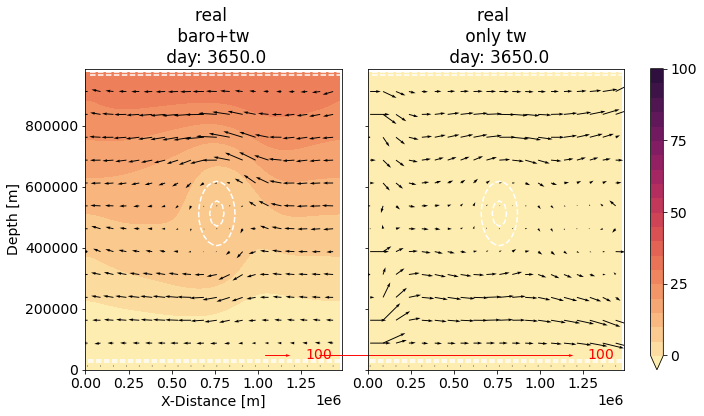

In [17]:
#plot streamfunction
wmin=0
wmax=100
lev=21
t=-1
cmap2=cmo.matter

fig,axes=plt.subplots(1,3,figsize=(10,6),gridspec_kw={'width_ratios':[1,1,0.05]})


ax=axes[0]
dsbrtu.psi.isel(T=t).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)#cbar_kwargs={'label':''})
dsbrtu.Depth.plot.contour(levels=[2500,3999],ax=ax,linestyles='--',colors='w')
q=ax.quiver(dsbrtu.X[0:-1:arr],dsbrtu.Y[0:-1:arr],grid.interp(dsbrtu.isel(T=t,Z=0).U_baro,'X',boundary='extend')[0:-1:arr,0:-1:arr],grid.interp(dsbrtu.isel(T=t,Z=0).V_baro,'Y',boundary='extend')[0:-1:arr,0:-1:arr])
ax.quiverkey(q,0.8,0.05,100,label='$100$',color='r',labelpos='E',labelcolor='r',labelsep=0.2)
ax.set_title(f'real \n baro+tw \n day: {dsbrtu.day.isel(T=t).values}')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('Depth [m]')

ax=axes[1]
cb=dsbrt.psi.isel(T=t).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)#cbar_kwargs={'label':''})
dsbrt.Depth.plot.contour(levels=[2500,3999],ax=ax,linestyles='--',colors='w')
q=ax.quiver(dsbrt.X[0:-1:arr],dsbrt.Y[0:-1:arr],grid.interp(dsbrt.isel(T=t,Z=0).U_baro,'X',boundary='extend')[0:-1:arr,0:-1:arr],grid.interp(dsbrt.isel(T=t,Z=0).V_baro,'Y',boundary='extend')[0:-1:arr,0:-1:arr])
ax.quiverkey(q,0.8,0.05,100,label='$100$',color='r',labelpos='E',labelcolor='r',labelsep=0.2)
ax.set_title(f'real \n only tw \n day: {dsbrt.day.isel(T=t).values}')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_yticklabels('')

cbar=plt.colorbar(cb,cax=axes[2], ticks=np.linspace(wmin,wmax,5))
plt.tight_layout()

In [18]:
#compute difference in SSH by removing the thermal wind component from the full SSH
bt_comp=(dsbrtu.Eta-dsbrt.Eta)


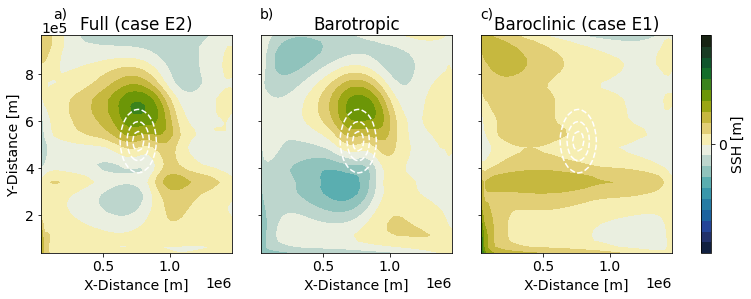

In [19]:
etamin=-0.03
etamax=0.03
etalev=21
etamap=cmo.delta

fig,axes=plt.subplots(1,4,figsize=(12,4),gridspec_kw={'width_ratios':[1,1,1,.05]})
ax=axes[0]
cb=(dsbrtu.Eta-dsbrtu.Eta.isel(X=58)).isel(X=slice(1,-1),Y=slice(1,-1),T=-1).plot.contourf(ax=ax,vmin=etamin,vmax=etamax,levels=etalev,cmap=etamap,add_colorbar=False)
dsbrt.Depth.isel(X=slice(1,59),Y=slice(1,-1)).plot.contour(levels=[2500,3500,4500],ax=ax,linestyles='--',colors='w')
ax.set_title('Full (case E2)')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('Y-Distance [m]')
ax.ticklabel_format(axis='both', style='scientific', scilimits=[-4,4])#, useOffset=None, useLocale=None, useMathText=None)
ax.text(0.1, 1.1, 'a)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
ax=axes[1]
(bt_comp-bt_comp.isel(X=58)).isel(X=slice(1,-1),Y=slice(1,-1),T=-1).plot.contourf(ax=ax,vmin=etamin,vmax=etamax,levels=etalev,cmap=etamap,add_colorbar=False)
dsbrt.Depth.isel(X=slice(1,59),Y=slice(1,-1)).plot.contour(levels=[2500,3500,4500],ax=ax,linestyles='--',colors='w')
ax.set_title('Barotropic')
ax.set_ylabel('')
ax.set_yticklabels('')
ax.set_xlabel('X-Distance [m]')
ax.text(0.03, 1.1, 'b)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
ax=axes[2]
(dsbrt.Eta-dsbrt.Eta.isel(X=58)).isel(X=slice(1,-1),Y=slice(1,-1),T=-1).plot.contourf(ax=ax,vmin=etamin,vmax=etamax,levels=etalev,cmap=etamap,add_colorbar=False)
dsbrt.Depth.isel(X=slice(1,59),Y=slice(1,-1)).plot.contour(levels=[2500,3500,4500],ax=ax,linestyles='--',colors='w')
ax.set_title('Baroclinic (case E1)')
ax.set_ylabel('')
ax.set_yticklabels('')
ax.set_xlabel('X-Distance [m]')
ax.text(0.03, 1.1, 'c)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)

plt.colorbar(cb,cax=axes[3],label='SSH [m]',ticks=np.linspace(-0.3,0.3,5)) 


<ipython-input-20-497dbdec7140>:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


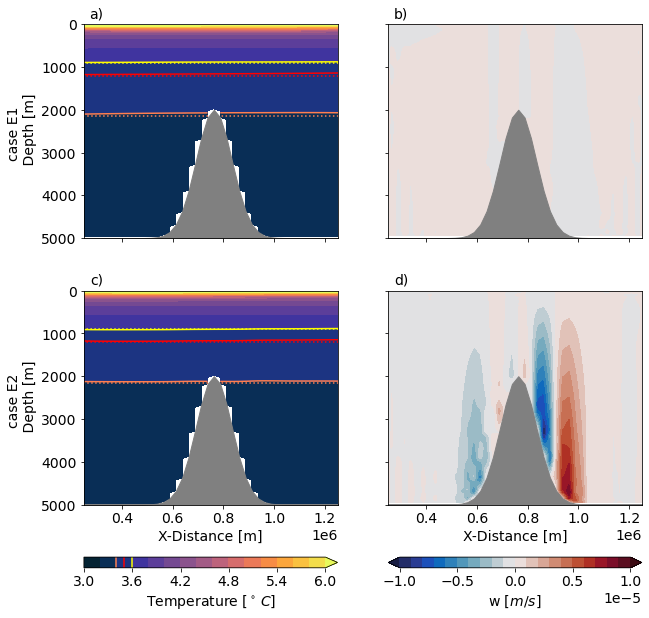

In [20]:
import matplotlib.ticker                         # here's where the formatter is
cbformat = matplotlib.ticker.ScalarFormatter()   # create the formatter
cbformat.set_powerlimits((-2,2))                 # set the limits for sci. not.

#plot T section  for 20 layer cases
t=-1

# T for real case
tmin2=3
tmax2=6
levt2=16
cmapt1=cmo.thermal
#plot Wsection  for 20 layer cases
wmin=-0.00001
wmax=0.00001
cmap2=cmo.balance
lev=21

fig,axes=plt.subplots(3,2,figsize=(10,10),gridspec_kw={'width_ratios':[1,1],'height_ratios':[1,1,.05],'hspace':.36})

# ------------case E1 --------------------------------------

ax = axes[0,0]
dsbrt.Temp.where(dsbrt.Temp>0).isel(T=t,Y=20).plot.contourf(cmap=cmapt1,vmin=tmin2,vmax=tmax2,levels=levt2,ax=ax,add_colorbar=False)
ax.fill_between(dsbrt.X,(dsbrt.Depth).isel(Y=20),5000,color='grey')
dsbrt.Temp.where(dsbrt.Temp>0).isel(T=t,Y=20).plot.contour(ax=ax,colors=['coral','r','yellow'],levels=[3.4,3.5,3.6])
dsbrt.Temp.where(dsbrt.Temp>0).isel(T=0,Y=20).plot.contour(ax=ax,colors=['coral','r','yellow'],levels=[3.4,3.5,3.6],linestyles=':')
ax.set_title(f'')
ax.set_xlabel('')#X-Distance [m]')
ax.set_ylabel('case E1 \n Depth [m]')
ax.set_xticklabels('')
ax.set_ylim((5000,0))
ax.set_xlim((0.25e6,1.25e6))
ax.text(0.05, 1.05, 'a)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)


ax = axes[0,1]
dsbrt.W.isel(T=t,Y=20).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)
ax.fill_between(dsbrt.X,(dsbrt.Depth).isel(Y=20),5000,color='grey')
ax.set_title(f'')
ax.set_xlabel('')
ax.set_yticklabels('')
ax.set_xticklabels('')
ax.set_ylabel('')
ax.set_ylim((5000,0))
ax.set_xlim((0.25e6,1.25e6))
ax.text(0.05, 1.05, 'b)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)


# ------------------ case E2 ----------------------------
ax =axes[1,0]
cbt2=(dsbrtu.Temp.where(dsbrtu.Temp>0).isel(T=t,Y=20)).plot.contourf(cmap=cmapt1,vmin=tmin2,vmax=tmax2,levels=levt2,ax=ax,add_colorbar=False)
cctt2=dsbrtu.Temp.where(dsbrtu.Temp>0).isel(T=t,Y=20).plot.contour(ax=ax,colors=['coral','r','yellow'],levels=[3.4,3.5,3.6])
dsbrtu.Temp.where(dsbrtu.Temp>0).isel(T=0,Y=20).plot.contour(ax=ax,colors=['coral','r','yellow'],levels=[3.4,3.5,3.6],linestyles=':')
ax.fill_between(dsbrtu.X,(dsbrtu.Depth).isel(Y=20),5000,color='grey')
ax.set_title(f'')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('case E2 \n Depth [m]')
ax.set_ylim((5000,0))
ax.set_xlim((0.25e6,1.25e6))
ax.text(0.05, 1.05, 'c)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)


ax = axes[1,1]
cbw=(dsbrtu.W.isel(T=t,Y=20)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)
ax.fill_between(dsbrtu.X,(dsbrtu.Depth).isel(Y=20),5000,color='grey')
#ax.set_title(f' e-scale \n thermal wind + uniform \n day: {dsbetu.day.isel(T=t).values}')
ax.set_title(f'')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('')
ax.set_ylim((5000,0))
ax.set_xlim((0.25e6,1.25e6))
ax.set_yticklabels('')
ax.text(0.05, 1.05, 'd)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)


cbar2=plt.colorbar(cbt2,cax=axes[2,0], orientation="horizontal",label='Temperature [$^\circ\,C$]',ticks=np.linspace(tmin2,tmax2,6))
cbar2.add_lines(cctt2)
cbar3=plt.colorbar(cbw,cax=axes[2,1], orientation="horizontal", ticks=np.linspace(wmin,wmax,5),label="w [$m/s$]",format=cbformat)

plt.tight_layout()
plt.savefig('figures/TW_sections_real_alongx.jpg',dpi=300)